In [1]:
from IPython.display import display

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import pickle

from collections import Counter
from scipy.optimize import curve_fit
from random import sample

#Matplotlib styles
%config InlineBackend.figure_format = 'retina'
plt.style.use(["science", "notebook"])

plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm'

plt.rcParams["legend.fancybox"] = False
plt.rcParams["legend.frameon"] = True
plt.rcParams["legend.edgecolor"] = "black"
plt.rcParams["legend.fontsize"] = 13
plt.rcParams["legend.framealpha"] = 1

plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12

plt.rcParams["axes.labelsize"] = 15
plt.rcParams["axes.titlesize"] = 17
plt.rcParams["axes.grid"] = True

plt.rcParams["grid.color"] = "gray"
plt.rcParams["grid.linestyle"] = (1, (4, 9))


In [2]:
def ordered_degree_list(G):
    """
    Ordenar nodos por grado (de mayor a menor).
    """
    deg = list(G.degree())
    deg.sort(key = lambda x: x[1], reverse = True)
    return [n for (n, d) in deg]

def order_dict_by_val(d):
    """
    Ordenar diccionario por valor.
    """
    return [k for k, v in sorted(d.items(), key=lambda x: x[1], reverse=True)]

def giant_component(G):
    """
    Obtiene la componente gigante de una red.
    """
    try:
        nodes_in_giant = max(nx.connected_components(G), key=len)
    except ValueError:
        raise ValueError("No existe componente gigante")

    gc = G.subgraph(nodes_in_giant).copy()
    return gc

## Carga de datasets

In [3]:
#Carga de DataFrames
df_y2h = pd.read_csv("datasets/yeast_Y2H.txt", delimiter = "\t", header = None, names = ["source", "target"])
df_apms = pd.read_csv("datasets/yeast_AP-MS.txt", delimiter = "\t", header = None, names = ["source", "target"])
df_lit = pd.read_csv("datasets/yeast_LIT.txt", delimiter = "\t", header = None, names = ["source", "target"])
df_litreg = pd.read_csv("datasets/yeast_LIT_Reguly.txt", delimiter = "\t")
df_litreg_mod = df_litreg.rename(columns = {"Bait gene/protein": "source", "Hit gene/protein": "target"})[["source", "target"]]

#Carga de Redes
graph_y2h = nx.from_pandas_edgelist(df_y2h)
graph_apms = nx.from_pandas_edgelist(df_apms)
graph_lit = nx.from_pandas_edgelist(df_lit)
graph_litreg = nx.from_pandas_edgelist(df_litreg_mod)

nets = {"Y2H": graph_y2h, "AP-MS": graph_apms, 
        "LIT": graph_lit, "LIT-Reguly": graph_litreg}

In [4]:
#Carga y modificación de Essential_ORFs_paperHe.txt

def parse_list(x):
    splitted = x.split(",")
    if len(splitted) == 1 and splitted[0] == "":
        return None
    return splitted

def remove_spaces(x):
    removed = x.replace(" ", "")
    if removed == "":
        return None
    return removed

ess = pd.read_csv("datasets/Essential_ORFs_paperHe.txt", delimiter="\t")
ess.drop(0, inplace=True) #Eliminamos los guiones.
ess.where(pd.notnull(ess), None, inplace=True) #Reemplaza los NaNs de numpy con Nones
ess.rename(columns = {"gene_names                                           ": "gene_names"}, inplace = True)

#Quitamos espacios innecesarios
ess["gene_names"] = ess["gene_names"].dropna().apply(remove_spaces)
ess["deletion_alias"] = ess["deletion_alias"].dropna().apply(remove_spaces)

#Parseamos listas
ess["gene_names"] = ess["gene_names"].dropna().apply(parse_list)


ess["ORF_name"] = ess["ORF_name"].dropna().apply(lambda x: x.replace(" ", "").upper())
ess_names = list(ess["ORF_name"].dropna().unique()) #Lista de nodos esenciales

display(ess.head(5))
print(ess_names[:5])

,rec_num,ORF_name,deletion_alias,gene_names,UPTAG_sequence_20mer,DNTAG_sequence_20mer
1,20406,YAL001C,None,"[TSV115, FUN24]",ACTATATGTGAAGGCATGGC,None
2,20404,YAL003W,None,[TEF5],GACATATCAGCATACATGGC,None
3,20383,YAL025C,None,NaN,TGCCGCATCAAAGAGGCCAA,None
4,20376,YAL032C,None,[FUN20],TGATCCGCGTCGATGCTCTT,None
5,20375,YAL033W,None,[FUN53],CTGACTTAGTGCATACTGCT,None


['YAL001C', 'YAL003W', 'YAL025C', 'YAL032C', 'YAL033W']


# Tablas

## Tabla 1: Propiedades de las redes

In [25]:
nodes = {k: len(set(g.nodes)) for k, g in nets.items()}
edges = {k: len(set(g.edges)) for k, g in nets.items()}
mean_deg = {k: np.mean([d for n, d in list(g.degree)]) for k, g in nets.items()}
avg_cc = {k: nx.average_clustering(g) for k, g in nets.items()}

tab1 = pd.DataFrame({"Nodos": nodes, "Enlaces": edges, "¿Densidad?": {k: edges[k]/nodes[k] for k in nodes.keys()}, "Grado medio": mean_deg, "Coef. Clustering medio": avg_cc})
display(tab1)

,Nodos,Enlaces,¿Densidad?,Grado medio,Coef. Clustering medio
Y2H,2018,2930,1.451933,2.903865,0.046194
AP-MS,1622,9070,5.591862,11.183724,0.554636
LIT,1536,2925,1.904297,3.808594,0.292492
LIT-Reguly,3307,11858,3.585727,7.171454,0.261134


## Tabla 2: Overlap entre redes

In [6]:
node_names = {k: set(g.nodes) for k, g in nets.items()}

#Calculo de overlap entre dos redes.
overlap = lambda nodes1, nodes2: len(nodes1.intersection(nodes2))/len(nodes2)
#Dada una red, calculo el overlap con las otras 3.
inter_dict = lambda net_name: {iter_name: overlap(node_names[net_name], iter_node_names) for iter_name, iter_node_names in node_names.items()}
#Consigo el diccionario anterior para las 4 redes.
intersections = {net_name: inter_dict(net_name) for net_name in nets.keys()}
tab2 = pd.DataFrame(intersections)
### Modifico los valores con 2 cifras significativas, y exporto a csv.
tab2 = tab2.applymap(lambda x: f"{x:.0%}")

tab2.to_csv("tabla2.csv")
display(tab2)

,Y2H,AP-MS,LIT,LIT-Reguly
Y2H,100%,36%,37%,66%
AP-MS,45%,100%,57%,88%
LIT,48%,60%,100%,99%
LIT-Reguly,40%,43%,46%,100%


In [7]:
links = {k: pd.DataFrame(list(g.edges), columns=['Source', 'Target']) for k, g in nets.items()}


def ordenar_abc(df: pd.DataFrame) -> pd.DataFrame:
    ordered_df = df.copy()
    for idx, nodes in ordered_df.iterrows():
        nodes = list(nodes)
        nodes.sort()
        ordered_df.loc[idx, 'Source'] = nodes[0]
        ordered_df.loc[idx, 'Target'] = nodes[1]
    return ordered_df


links = {k: ordenar_abc(edge_df) for k, edge_df in links.items()}

In [8]:
#Calculo de overlap entre dos redes.
overlap = lambda df1, df2: len(pd.merge(df1, df2, how='inner', on=['Source', 'Target']))/len(df2)
#Dada una red, calculo el overlap con las otras 3.
inter_dict = lambda net_name: {iter_name: overlap(links[net_name], iter_links) for iter_name, iter_links in links.items()}
#Consigo el diccionario anterior para las 4 redes.
intersections = {net_name: inter_dict(net_name) for net_name in nets.keys()}
tab2 = pd.DataFrame(intersections)
### Modifico los valores con 2 cifras significativas, y exporto a csv.
tab2 = tab2.applymap(lambda x: f"{x:.0%}")

tab2.to_csv("tabla2_bis.csv")
display(tab2)


,Y2H,AP-MS,LIT,LIT-Reguly
Y2H,100%,9%,9%,16%
AP-MS,3%,100%,14%,28%
LIT,9%,44%,100%,98%
LIT-Reguly,4%,21%,24%,100%


## Tabla 3

In [9]:
#--------------------------------------------------------------------------------------------------------------------
### COLUMNA 1 (Revisando)

def get_random_gc_frac(G):
    """
    Consigue la fracción de la componente gigante de una red G tras eliminar nodos
    con la misma distribución de grados que los nodos esenciales "ess_names".
    """
    global ess_names
    
    ### Conseguimos los nodos esenciales en la red, junto a su grado
    Gcopy = G.copy()

    #Como normalizamos usando la GC, vamos a iterar siempre sobre este.
    gc = giant_component(Gcopy) 
    
    #Nodos y grado de la gc.
    degrees = dict(gc.degree())
    nodes = list(gc.nodes())

    #La lista toma los valores de los grados para el i-esimo nodo esencial, 
    # si está en la red. Despues armamos un contador para conocer la distribución. 
    ess_degree_dist = dict(Counter([degrees[n] for n in ess_names if n in nodes]))

    #Armamos un dict de la forma -> grado: [nombres de nodos con ese grado]
    nodes_by_degree = {}
    for i_degree in ess_degree_dist.keys():
        nodes_by_degree[i_degree] = [n for n, n_d in degrees.items() if n_d == i_degree]

    #Nos quedamos, para cada grado, la misma cantidad de nodos
    #aleatorios que los encontrados en ess_degree_dist.
    random_nodes = []
    for d in ess_degree_dist.keys():
        sampled_nodes = sample(nodes_by_degree[d], ess_degree_dist[d]) #sample(lista de valores, cantidad de valores)
        assert len(sampled_nodes) == ess_degree_dist[d] #Sample debería evitar repetidos.
        random_nodes += sampled_nodes 

    #Ya tengo la distribución, ahora elimino los nodos que conseguí.

    cg_before = giant_component(Gcopy) #Obtenemos la componente gigante de la red
    N_gc_before = len(list(cg_before.nodes()))

    cg_before.remove_nodes_from(random_nodes) #Eliminamos todos los nodos esenciales presentes en la red.

    cg_after = giant_component(cg_before) #Nos quedamos con la componente gigante tras eliminar los nodos esenciales.
    N_gc_after = len(list(cg_after.nodes()))

    return N_gc_after / N_gc_before #Fracción tamaño GC: despues / antes


#Ejecutamos el experimento 100 veces para cada red y calculamos la media.
random_fracs = {net_name: [get_random_gc_frac(net) for i in range(100)] for net_name, net in nets.items()}

random_fracs_mean = {net_name: f"{np.mean(val):.3f} +- {np.std(val, ddof=1):.2g}" for net_name, val in random_fracs.items()}

#--------------------------------------------------------------------------------------------------------------------
### COLUMNA 2 (Revisada, es igual que el código de la Figura 3)

ess_final_size = {}
for net_name, net in nets.items():
    Gcopy = net.copy()

    cg_before = giant_component(Gcopy) #Obtenemos la componente gigante de la red
    N_gc_before = len(list(cg_before.nodes()))

    cg_before.remove_nodes_from(ess_names) #Eliminamos todos los nodos esenciales presentes en la red.

    cg_after = giant_component(cg_before) #Nos quedamos con la componente gigante tras eliminar los nodos esenciales.
    N_gc_after = len(list(cg_after.nodes()))

    ess_final_size[net_name] = N_gc_after / N_gc_before #Fracción despues/antes

tab3 = pd.DataFrame([ess_final_size, random_fracs_mean], index=["Essential", "Random"]).T
display(tab3)

,Essential,Random
Y2H,0.624165,0.600 +- 0.011
AP-MS,0.323705,0.385 +- 0.05
LIT,0.281121,0.105 +- 0.043
LIT-Reguly,0.570099,0.525 +- 0.0098


## Tabla 5

In [18]:
lineal = lambda x, a, b: a*x + b

def get_Pe(G):
    """
    Consigue los valores de Pe para cada k.
    """
    global ess_names

    gc = giant_component(G)

    nodes = list(gc.nodes())
    degrees = dict(gc.degree())

    degree_dist = dict(Counter(degrees.values()))
    ess_degrees_in_net = dict(Counter([degrees[n] for n in ess_names if n in nodes]))
    
    Pe = {k: ess_degrees_in_net[k]/degree_dist[k] for k in ess_degrees_in_net.keys()}

    return np.array(list(Pe.keys())), np.array(list(Pe.values())) 

def fit_linear(G, max_k = 12, weighted: bool = False, PLOT: bool = False):
    "Ajuste lineal de k vs ln(1-Pe) para una red G. Devuelve [ln(1-alfa), ln(1-beta)]"
    x_G, y_G = get_Pe(G)

    y_G = y_G[x_G < max_k]
    x_G = x_G[x_G < max_k]

    if not weighted:
        popt, pcov = curve_fit(lineal, x_G, np.log(1 - y_G))
    else:
        #El ajuste va pesado con la fracción de nodos que tienen grado k. (Nodos de grado k / Total de nodos).
        gc = giant_component(G)

        nodes = list(gc.nodes())
        degrees = dict(gc.degree())
        
        #Guardamos la cantidad de nodos de grado k, y construimos el array de pesos.
        degree_dist = dict(Counter(degrees.values()))
        sigma = np.array([degree_dist[i]/len(nodes) for i in range(1, max_k)])
        
        popt, pcov = curve_fit(lineal, x_G, np.log(1 - y_G), sigma = sigma)

    if PLOT:
        x_smooth = np.linspace(np.min(x_G), np.max(x_G))
        plt.errorbar(x_G, np.log(1 - y_G), fmt="o")
        plt.plot(x_smooth, lineal(x_smooth, *popt))
        plt.xlim(0, 13)
        plt.xlabel("$k$")
        plt.ylabel("$ln(1 - P_e)$")
        plt.show()

    return popt

def get_col12_tab5(G):
    """
    Calcula los valores de las columnas 1 y 2 (Total number of pairs) 
    y (Number of pairs of the same type)de la tabla 5 para una red G.
    """
    Gcopy = G.copy()
    
    #Propiedades de la red
    edges = list(Gcopy.edges())
    nodes = list(Gcopy.nodes())

    #nodo: [vecinos]
    neighbors_by_node = {node: [n for n in nx.neighbors(G, node)] for node in nodes}

    #Contadores
    same_type, total = 0, 0

    #Lista de nodos en los que vamos a pivotar
    n1_list = list(neighbors_by_node.keys())
    for n1 in n1_list:
        #Creamos otra copia de n1_list y le quitamos el pivote porque no queremos ver
        # a él mismo
        n2_list = list(neighbors_by_node.keys())
        n2_list.remove(n1)
        for n2 in n2_list:
            #Si comparten tres vecinos en comun.
            if len(set(neighbors_by_node[n1]).intersection(set(neighbors_by_node[n2]))) >= 3:
                total += 1
                if (n1 in ess_names) == (n2 in ess_names):
                    same_type += 1 #Solo son del mismo tipo si True==True, o False==False.

    return total, same_type

def get_col3_tab5(G, DEBUG: bool = False):
    """
    Consigue el valor de la columna 3 (Simulation) de la tabla 5 para una red G.
    """

    """ Prueba con red ER. No dá lo que queremos. Ya no se que probar de la simulación.
    
    n = len(list(G.nodes()))
    m = len(list(G.edges()))
    p = 2*m/n/(n-1)
    randomG = nx.erdos_renyi_graph(n, p)
    mapping = dict(zip(range(n), list(G.nodes())))
    randomG = nx.relabel_nodes(randomG, mapping)
    
    """
    
    #No dá lo que tiene que dar.
    swaps = len(list(G.edges()))
    randomG = nx.double_edge_swap(Gcopy, nswap = swaps, max_tries = 5*swaps)
    
    #Obtención de alfa, beta, y Pe.
    popt_G = fit_linear(randomG, PLOT = DEBUG)
    Pe = dict(zip(np.arange(1, 350), 1 - np.exp(lineal(np.arange(1, 350), *popt_G))))
    alpha_G, beta_G = 1 - np.exp(popt_G[0]), 1 - np.exp(popt_G[1])
    
    if DEBUG:
        print(f"{net_name}: {alpha_G=}, {beta_G=}")

    #Copia de red y obtención de propiedades
    randomGcopy = randomG.copy()
    edges = list(randomGcopy.edges())
    nodes = list(randomGcopy.nodes())
    degrees = dict(randomGcopy.degree())
    
    #{nombre del nodo: [nombre de los vecinos]}
    neighbors_by_node = {node: [n for n in nx.neighbors(randomGcopy, node)] for node in nodes}
    
    #Lista de nombres de nodos.
    n1_list = list(neighbors_by_node.keys())

    i = 0
    for n1 in n1_list: #Para cada nodo

        #Creamos una copia y le sacamos el que estamos iterando
        n2_list = list(neighbors_by_node.keys())
        n2_list.remove(n1)
        
        for n2 in n2_list: #Miramos cada par de nodos con n1.

            #Si comparten por lo menos tres vecinos
            if len(set(neighbors_by_node[n1]).intersection(set(neighbors_by_node[n2]))) >= 3:

                #Grados de los nodos n1, n2
                k1 = degrees[n1]
                k2 = degrees[n2]

                #Valores de Pe de n1 y n2.
                P1 = Pe[k1]
                P2 = Pe[k2]

                #Cuenta rara de Eitu                
                i += 2*P1*P2 - P1 - P2 + 1

    return i

def get_col4_tab5(G, DEBUG: bool = False):
    """
    Consigue el valor de la columna 4 (Line fitting) de la tabla 5 para una red G.
    """

    #Obtención de alfa, beta, y Pe.
    popt_G = fit_linear(G, PLOT = DEBUG)
    Pe = dict(zip(np.arange(1, 350), 1 - np.exp(lineal(np.arange(1, 350), *popt_G))))
    alpha_G, beta_G = 1 - np.exp(popt_G[0]), 1 - np.exp(popt_G[1])
    
    if DEBUG:
        print(f"{net_name}: {alpha_G=}, {beta_G=}")

    #Copia de red y obtención de propiedades
    Gcopy = G.copy()
    edges = list(Gcopy.edges())
    nodes = list(Gcopy.nodes())
    degrees = dict(Gcopy.degree())
    
    #{nombre del nodo: [nombre de los vecinos]}
    neighbors_by_node = {node: [n for n in nx.neighbors(G, node)] for node in nodes}
    
    #Lista de nombres de nodos.
    n1_list = list(neighbors_by_node.keys())

    i = 0
    for n1 in n1_list: #Para cada nodo

        #Creamos una copia y le sacamos el que estamos iterando
        n2_list = list(neighbors_by_node.keys())
        n2_list.remove(n1)
        
        for n2 in n2_list: #Miramos cada par de nodos con n1.

            #Si comparten por lo menos tres vecinos
            if len(set(neighbors_by_node[n1]).intersection(set(neighbors_by_node[n2]))) >= 3:

                #Grados de los nodos n1, n2
                k1 = degrees[n1]
                k2 = degrees[n2]

                #Valores de Pe de n1 y n2.
                P1 = Pe[k1]
                P2 = Pe[k2]

                #Cuenta rara de Eitu                
                i += 2*P1*P2 - P1 - P2 + 1

    return i

def get_col5_tab5(G, DEBUG: bool = False):
    """
    Consigue el valor de la columna 5 (Weighted Line fitting) de la tabla 5 para una red G.
    """

    #Obtención de alfa, beta, y Pe.
    popt_G = fit_linear(G, weighted = True, PLOT = DEBUG)
    Pe = dict(zip(np.arange(1, 350), 1 - np.exp(lineal(np.arange(1, 350), *popt_G))))
    alpha_G, beta_G = 1 - np.exp(popt_G[0]), 1 - np.exp(popt_G[1])

    #Copia de red y obtención de propiedades
    Gcopy = G.copy()
    edges = list(Gcopy.edges())
    nodes = list(Gcopy.nodes())
    degrees = dict(Gcopy.degree())
    
    #{nombre del nodo: [nombre de los vecinos]}
    neighbors_by_node = {node: [n for n in nx.neighbors(G, node)] for node in nodes}
    
    #Lista de nombres de nodos.
    n1_list = list(neighbors_by_node.keys())

    i = 0
    for n1 in n1_list: #Para cada nodo

        #Creamos una copia y le sacamos el que estamos iterando
        n2_list = list(neighbors_by_node.keys())
        n2_list.remove(n1)
        
        for n2 in n2_list: #Miramos cada par de nodos con n1.

            #Si comparten por lo menos tres vecinos
            if len(set(neighbors_by_node[n1]).intersection(set(neighbors_by_node[n2]))) >= 3:

                #Grados de los nodos n1, n2
                k1 = degrees[n1]
                k2 = degrees[n2]

                #Valores de Pe de n1 y n2.
                P1 = Pe[k1]
                P2 = Pe[k2]

                #Cuenta rara de Eitu                
                i += 2*P1*P2 - P1 - P2 + 1

    return i

for net_name, G in nets.items():
    Results_G = *get_col12_tab5(G), np.round(get_col3_tab5(G), 2), np.round(get_col4_tab5(G), 2), np.round(get_col5_tab5(G), 2)
    print(f"Para {net_name}:\n\tColumna1: {Results_G[0]}\n\tColumna2: {Results_G[1]}\n\tColumna3: {Results_G[2]}\n\tColumna4: {Results_G[3]}\n\tColumna5: {Results_G[4]}")
    print("\n")

Para Y2H:
	Columna1: 1318
	Columna2: 876
	Columna3: 10832.11
	Columna4: 705.59
	Columna5: 711.72


Para AP-MS:
	Columna1: 39322
	Columna2: 22662
	Columna3: 10223.99
	Columna4: 20538.25
	Columna5: 20029.76


Para LIT:
	Columna1: 3634
	Columna2: 2138
	Columna3: 10117.29
	Columna4: 2017.3
	Columna5: 1973.33


Para LIT-Reguly:
	Columna1: 32832
	Columna2: 19470
	Columna3: 11101.34
	Columna4: 17779.49
	Columna5: 18057.25




# Figuras

## Figura 1: Fracción de nodos esenciales restantes al remover "hubs"

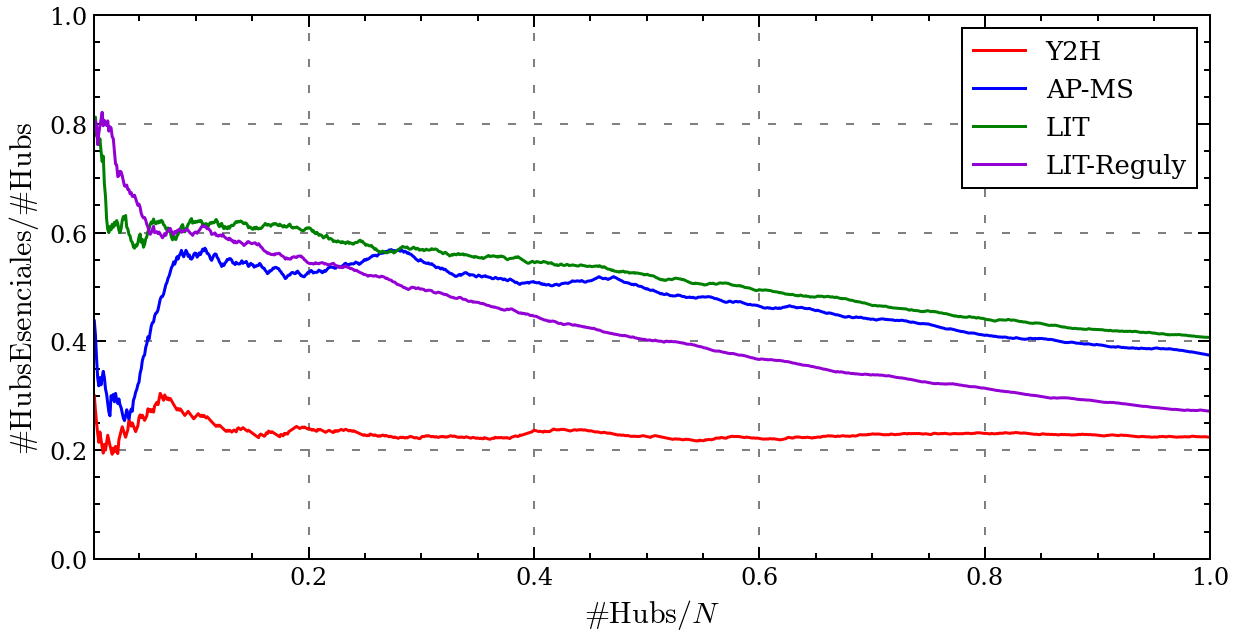

In [20]:
def ess_frac(G):
    """
    Calcula la fracción de nodos esenciales para distintas proporciones.
    """
    global ess_names
    
    #Init
    hubs_frac = np.linspace(0.01,1,1000)
    order_degree = ordered_degree_list(G)
    ess_hubs_frac = []
    
    for p in hubs_frac:
        hubs_amount = int(len(G.nodes())*p)
        ess_hubs = set(order_degree[:hubs_amount]).intersection(ess_names)
        ess_hubs_frac.append(len(ess_hubs)/hubs_amount) #esto es la cantidad de hubs que son esenciales
    
    return hubs_frac, ess_hubs_frac

hf_y2h, ehf_y2h = ess_frac(graph_y2h)
hf_apms, ehf_apms = ess_frac(graph_apms)
hf_lit, ehf_lit = ess_frac(graph_lit)
hf_litreg, ehf_litreg = ess_frac(graph_litreg)

fig, ax = plt.subplots(1, 1, figsize = (10,5))

ax.plot(hf_y2h, ehf_y2h, lw=1.5, color = "red", label = "Y2H")
ax.plot(hf_apms, ehf_apms, lw=1.5, color = "blue", label = "AP-MS")
ax.plot(hf_lit, ehf_lit, lw=1.5, color = "green", label = "LIT")
ax.plot(hf_litreg, ehf_litreg, lw=1.5, color = "darkviolet", label = "LIT-Reguly")
ax.set_xlim(0.01, 1)
ax.set_ylim(0, 1)
ax.set_ylabel(r"$\# \mathrm{HubsEsenciales}/\# \mathrm{Hubs}$")# "Fracción de nodos esenciales"
ax.set_xlabel(r"$\# \mathrm{Hubs}/N$") # "Fracción de hubs"
ax.legend()

plt.show()

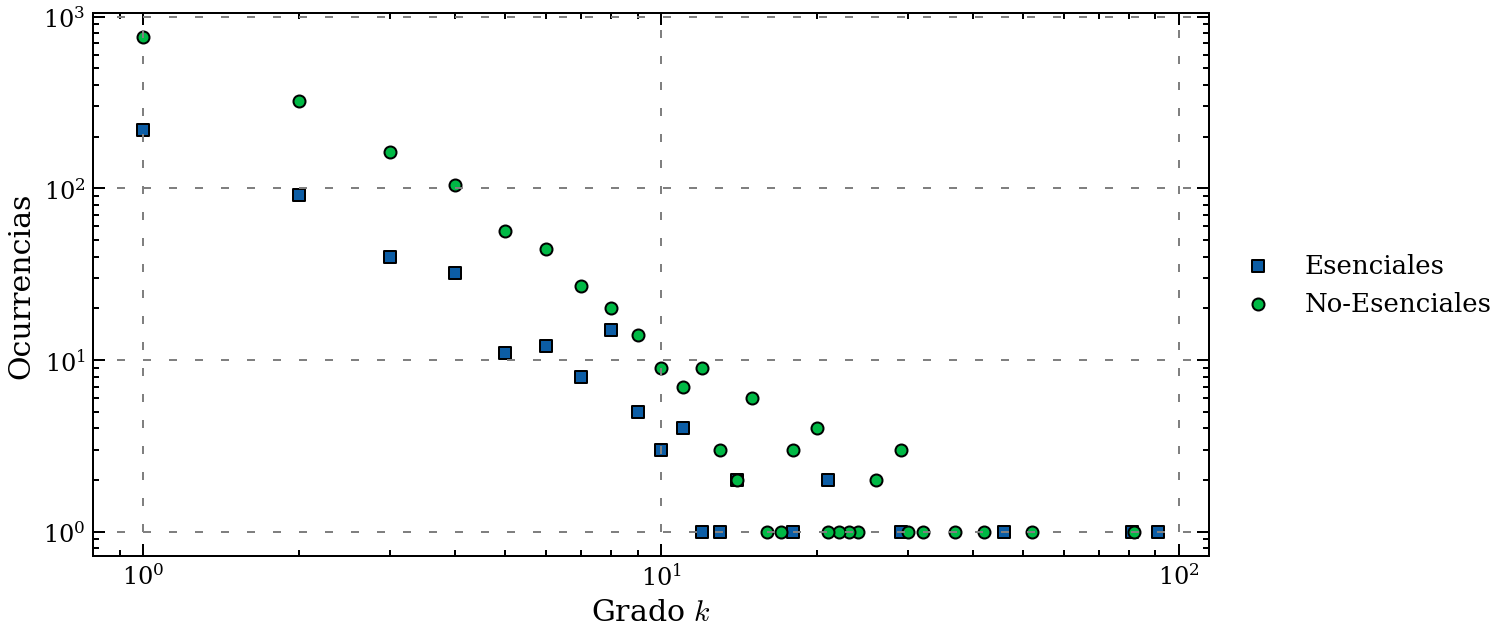

In [21]:
# from plfit import plfit

nodes_in_y2h = list(graph_y2h.nodes())
degrees_y2h = dict(graph_y2h.degree())
ess_nodes_in_y2h = [n for n in nodes_in_y2h if n in ess_names]
non_ess_nodes_in_y2h = [n for n in nodes_in_y2h if n not in ess_names]

ess_degree = [degrees_y2h[k] for k in ess_nodes_in_y2h]
ess_degree_dist = Counter(ess_degree)

non_ess_degree = [degrees_y2h[k] for k in non_ess_nodes_in_y2h]
non_ess_degree_dist = Counter(non_ess_degree)

# ess_fit = plfit(ess_degree)
# Kmin = ess_fit._xmin
# gamma = round(ess_fit._alpha, 3)
# k_sat = round(ess_fit._ks, 2)
# ess_x = np.array(list(ess_degree_dist.keys()))
# norm = np.sum(ess_x>Kmin)
# ess_y = ((gamma-1)*Kmin**(gamma-1)*ess_x**-gamma)/norm
# print(gamma)


# non_ess_fit = plfit(non_ess_degree)
# Kmin = non_ess_fit._xmin
# gamma = round(non_ess_fit._alpha, 3)
# k_sat = round(non_ess_fit._ks, 2)
# non_ess_x = np.array(list(non_ess_degree_dist.keys()))
# norm = np.sum(non_ess_x>Kmin)
# non_ess_y = ((gamma-1)*Kmin**(gamma-1)*non_ess_x**-gamma)/norm
# print(gamma)

fig, ax = plt.subplots(1, 1, figsize = (10, 5))
ax.scatter(ess_degree_dist.keys(), np.array(list(ess_degree_dist.values())),
           marker='s', ec="black", label='Esenciales')
ax.scatter(non_ess_degree_dist.keys(), np.array(list(non_ess_degree_dist.values())),
           marker='o', ec="black", label="No-Esenciales")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Grado $k$")
ax.set_ylabel("Ocurrencias")
# ax.axvline(np.mean(non_ess_degree), label="Grado medio", color="red", linestyle="--")
#ax.plot(non_ess_x[(non_ess_x > Kmin)], non_ess_y[(non_ess_x > Kmin)])
ax.legend(bbox_to_anchor=(1, 0.5), loc="center left", frameon=False)

plt.savefig("Distribucion Y2H.png", dpi = 300)
plt.show()

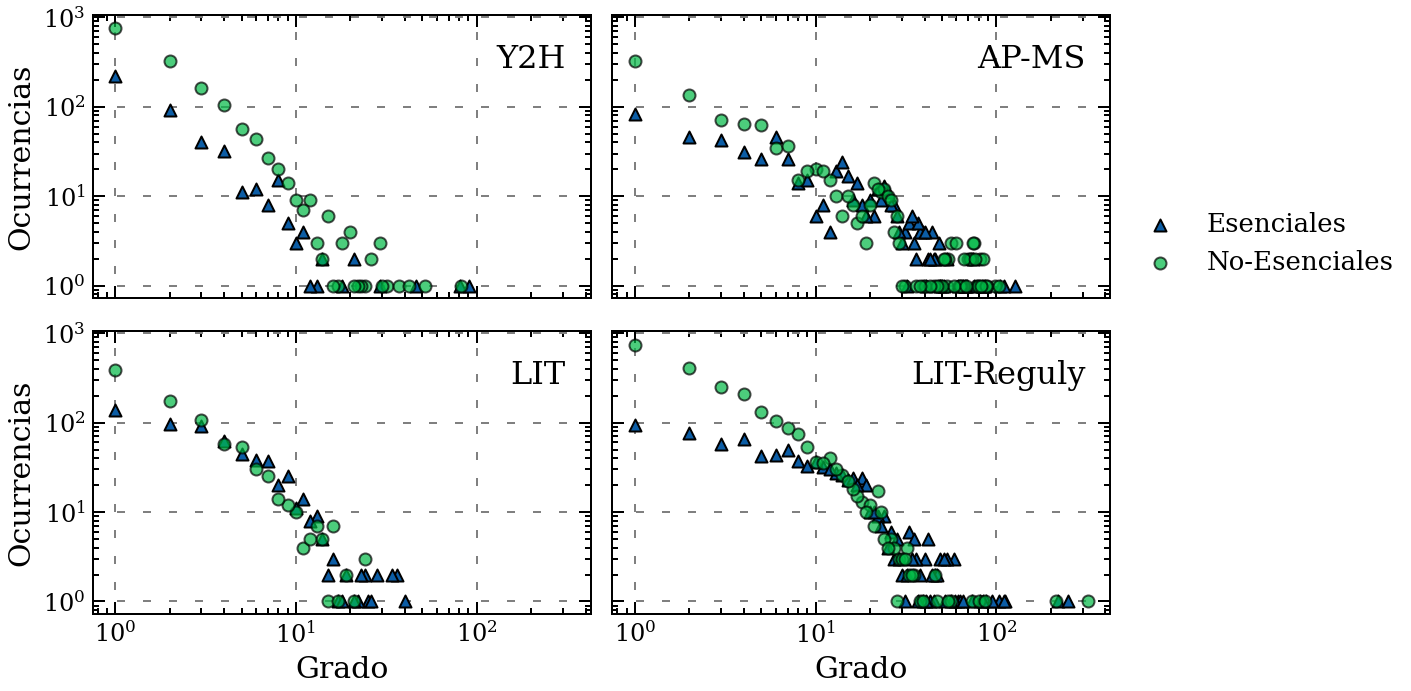

In [22]:
fig, axs = plt.subplots(2, 2, figsize = (10, 5), sharex=True, sharey=True, tight_layout=True)
for (net_name, graph_net), ax in zip(nets.items(), axs.flatten()):
    nodes_in_net = list(graph_net.nodes())
    degrees_net = dict(graph_net.degree())
    ess_nodes_in_net = [n for n in nodes_in_net if n in ess_names]
    non_ess_nodes_in_net = [n for n in nodes_in_net if n not in ess_names]

    ess_degree = [degrees_net[k] for k in ess_nodes_in_net]
    ess_degree_dist = Counter(ess_degree)

    non_ess_degree = [degrees_net[k] for k in non_ess_nodes_in_net]
    non_ess_degree_dist = Counter(non_ess_degree)
    
    ax.scatter(ess_degree_dist.keys(), np.array(list(ess_degree_dist.values())),
            marker='^', ec="black", alpha=1, zorder=9, label='Esenciales')
    ax.scatter(non_ess_degree_dist.keys(), np.array(list(non_ess_degree_dist.values())),
            marker='o', ec="black", alpha=0.7, zorder=10, label="No-Esenciales")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.text(0.95, 0.9, net_name, ha='right', va='top', transform=ax.transAxes, fontsize=16)

axs[1, 0].set_xlabel("Grado")
axs[1, 1].set_xlabel("Grado")
axs[0, 0].set_ylabel("Ocurrencias")
axs[1, 0].set_ylabel("Ocurrencias")
axs[0, 1].legend(bbox_to_anchor=(1, 0.), loc="lower left", frameon=False)

plt.savefig("dist grado esenciales.png", dpi=300)
plt.show()

## Figura 3: Tamaño de la componente principal al remover nodos según su centralidad

In [16]:
#Romper red
def break_network(G, remove_func, max_frac: float = 0.5):
    cg = giant_component(G)
    cg_size = len(cg.nodes())
    cg_frac = []
    removed_frac = []
    i = 1
    while i < cg_size*max_frac:
        # Tomamos el nodo a sacar usando la funcion pasada
        removing_node = remove_func(cg)
        # Lo sacamos
        cg.remove_node(removing_node)
        # Nos quedamos con la nueva componente gigante
        try:
            cg = giant_component(cg)
        except ValueError:
            break
        # Guardamos la fracción que queda (Es más util guardar el tamaño total y después ver que hacemos para normalizar).
        remaining_frac = len(cg.nodes()) #Tamaño actual
        cg_frac.append(remaining_frac)
        # Guardamos la fracción que ya sacamos
        removed_frac.append(i/cg_size) #Fracción de nodos que saque de la componente Princial / tamaño de la componente principal original.
        
        i+=1
        
    return removed_frac, cg_frac

#Guardado de objetos
def save_destruction(obj, filename):
    with open(filename, 'wb') as f:
        pickle.dump(obj, f)
        
#Carga de objetos
def load_destruction(filename):
    with open(filename, "rb") as f:
        dest = pickle.load(f)
    return dest

Primero calculamos tres centralidades y guardamos.

In [17]:
###Funciones para calcular centralidad
def max_degree_centrality(G):
  # Calcula la centralidad de grado
  centrality = nx.degree_centrality(G)
  # Devuelve el nodo de máxima centralidad
  return max(centrality, key = centrality.get)

def max_betweenness_centrality(G):
  # Calcula la centralidad de grado
  centrality = nx.betweenness_centrality(G)
  # Devuelve el nodo de máxima centralidad
  return max(centrality, key = centrality.get)

def max_closeness_centrality(G):
  # Calcula la centralidad de grado
  centrality = nx.closeness_centrality(G)
  # Devuelve el nodo de máxima centralidad
  return max(centrality, key = centrality.get)

# Tuve que subir la tolerancia de 1e-6 a 1e-3. No sé que tan malo será, pero sino no se ejecutaba.
def max_eigenvector_centrality(G):
  # Calcula la centralidad de grado
  centrality = nx.eigenvector_centrality(G, max_iter=100, tol=1e-03, nstart=None, weight='weight')
  # Devuelve el nodo de máxima centralidad
  return max(centrality, key = centrality.get)

centralities = {"Degree": max_degree_centrality, "Betweenness": max_betweenness_centrality, 
                "Closeness": max_closeness_centrality, "Eigenvector": max_eigenvector_centrality}

dest_dict = {} #Red1: {Centralidad1: valores, Centralidad2: valores...}
for name, graph in nets.items():
    vals = {}
    print(f"For {name}:")
    try:
        vals = load_destruction("dest"+name+".dict")
        print(f"{name} loaded.")

    except:
        for cent_name, func in centralities.items():
            print(f"\tDestroying using {cent_name}.")
            vals[cent_name] = break_network(graph, func)
        save_destruction(vals, "dest"+name+".dict")
        print(f"{name} saved.")
        
    finally:
        dest_dict[name] = vals

For Y2H:
Y2H loaded.
For AP-MS:
AP-MS loaded.
For LIT:
LIT loaded.
For LIT-Reguly:
LIT-Reguly loaded.


Agregamos la aleatoria por separado porque se corre rapido.

In [18]:
from tqdm import tqdm

def random_node(G):
    from random import choice
    return choice(list(G.nodes))

def fill_with_nan(x, N):
    if len(x) > N:
        raise ValueError("Array size greather than N.")
    return np.concatenate([x, np.empty(N - len(x))])

def get_random_vals(netname):
    #removed_frac, cg_frac for 0 and 1
    max_len = max([len(random_vals[netname][i][0]) for i in range(D)])
    arg_max_len = np.argmax([len(random_vals[netname][i][0]) for i in range(D)])
    
    gcsize = len(list(giant_component(nets[netname]).nodes()))
    
    filled = np.array([fill_with_nan(random_vals[netname][i][1], max_len) for i in range(D)])
    filledmean = np.nanmean(filled, axis = 0)
    filledmean_norm = np.nanmean(filled/gcsize, axis = 0)

    removed_frac = np.array([random_vals[netname][i][0] for i in range(D)][arg_max_len])
    removed_frac = removed_frac[abs(filledmean_norm) < 1]
    
    filledmean = filledmean[abs(filledmean_norm) < 1]

    return removed_frac, filledmean

try:
    dest_dict2 = load_destruction("Randoms.dict")
    print("Loaded Random.")
except:
    D = 20
    random_vals = {}
    for name, graph in nets.items():
        non_prom_random = []
        print(f"For {name}:")
        for i in tqdm(range(D)):
            non_prom_random.append(break_network(graph, random_node))
        random_vals[name] = non_prom_random

    dest_dict2 = {}
    for netname in nets.keys():
        dest_dict2[netname] = {"Random": get_random_vals(netname)}
    
    save_destruction(dest_dict2, "Randoms.dict")


Loaded Random.


Normalización

In [19]:
dest_dict_u = {n: {**dest_dict[n], **dest_dict2[n]} for n in dest_dict.keys()}
dest_dict_u_copy = dest_dict_u.copy()
c_names = ["Degree", "Betweenness", "Closeness", "Eigenvector", "Random"]

for n in nets.keys(): #Para cada red.
    for c in c_names: #Para cada centralidad.
        dest_dict_u_copy[n][c] = np.array(dest_dict_u_copy[n][c]) #Convierto la tupla en una lista. 
        gc_size = len(list(giant_component(nets[n]).nodes()))
        dest_dict_u_copy[n][c][1] = np.array(dest_dict_u_copy[n][c][1])/gc_size

Calculamos los puntos del gráfico para los nodos esenciales

In [20]:
def get_ess_dot(G):
    """
    Consigue, para una dada red G, el tamaño de la componente gigante tras eliminar todos los nodos esenciales
    presentes en la misma, y la fracción de nodos eliminados en la red. 
    """
    global ess_names

    ### x: Eliminamos todos los esenciales. Que fracción de eliminados es?
    gc = giant_component(G)
    ess_nodes_in_net = [n for n in ess_names if n in list(gc.nodes())] #Nodos esenciales en la red.
    x_ess_dot = len(ess_nodes_in_net)/len(list(giant_component(nets[net_name]).nodes())) #Nodos eliminados / Nodos de la CG

    ### y: Que tamaño tiene la componente gigante tras eliminar todos los nodos esenciales?
    Gcopy = G.copy()

    cg_before = giant_component(Gcopy) #Componente gigante antes de eliminar los nodos esenciales.
    N_cg_before = len(list(cg_before.nodes()))

    Gcopy.remove_nodes_from(ess_names) #Eliminamos los nodos esenciales en la red.
   
    cg_after = giant_component(Gcopy) #Componente gigante despues de eliminar los nodos esenciales.
    N_cg_after = len(list(cg_after.nodes()))
    
    y_ess_dot = N_cg_after / N_cg_before #Tamaño CG despues / Tamaño CG antes
    
    return (x_ess_dot, y_ess_dot)

#Conseguimos el punto para cada red
ess_dots = {}
for net_name, net in nets.items():
    ess_dots[net_name] = get_ess_dot(net)

print(ess_dots)

{'Y2H': (0.2185792349726776, 0.6241651487553127), 'AP-MS': (0.4043824701195219, 0.3237051792828685), 'LIT': (0.4245671887881286, 0.281121187139324), 'LIT-Reguly': (0.2714019851116625, 0.5700992555831266)}


Finalmente graficamos

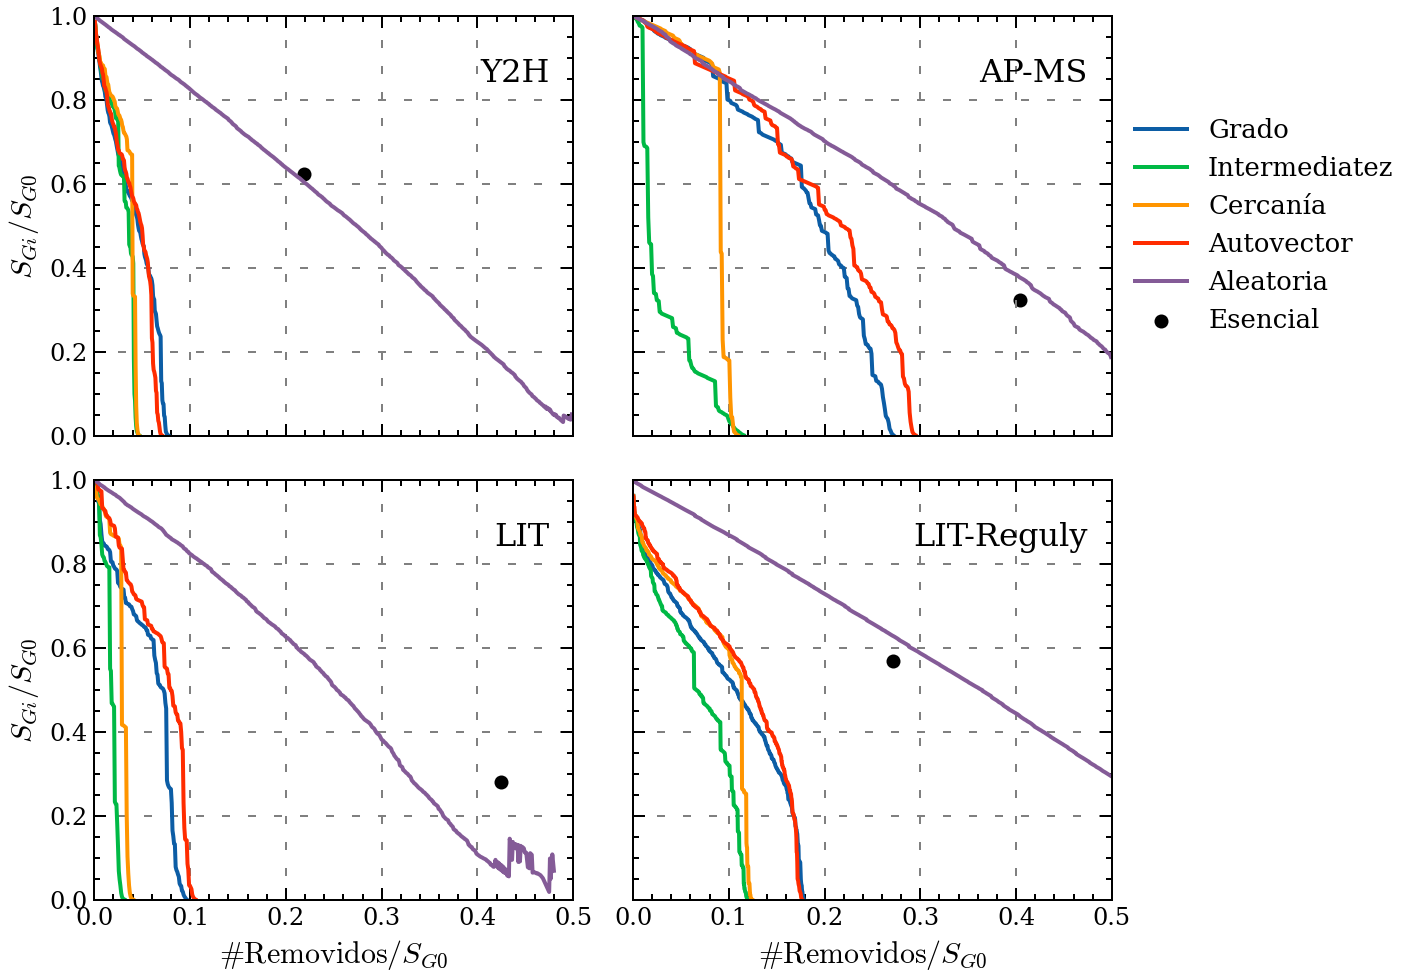

In [21]:
fig, axs = plt.subplots(2, 2, figsize = (10, 7), tight_layout=True, sharex=True, sharey=True)
axs = axs.flatten()
labels_esp = {"Degree": "Grado",
              "Betweenness": "Intermediatez",
              "Closeness": "Cercanía",
              "Eigenvector": "Autovector",
              "Random": "Aleatoria",}
#Para cada red
for i, (net_name, net_dest_vals) in enumerate(dest_dict_u_copy.items()): 
    #Para cada centralidad
    for cent_name, vals in net_dest_vals.items():
        #Al final no pedían Subgraph. La sacamos.
        if cent_name not in ("Subgraph"):
            axs[i].plot(vals[0], vals[1], label=labels_esp[cent_name])
        
    # ax[i].set_title(net_name)
    axs[i].text(0.95, 0.9, net_name, ha='right', va='top',
               transform=axs[i].transAxes, fontsize=16)
    
    axs[i].set_ylim(0, 1)
    axs[i].set_xlim(0, 0.5)
    
    x_ess_dot, y_ess_dot = ess_dots[net_name]
    axs[i].scatter(x_ess_dot, y_ess_dot, color = "black", label="Esencial")
    
axs[2].set_xlabel(r"$\# \mathrm{Removidos} / S_{G0}$")  # "Fracción de nodos removidos"
axs[3].set_xlabel(r"$\# \mathrm{Removidos} / S_{G0}$")  # "Fracción de nodos removidos"
axs[0].set_ylabel(r"$S_{Gi}  / S_{G0}$")  # "Fracción de nodos en\nla componente\ngigante restantes"
axs[2].set_ylabel(r"$S_{Gi} / S_{G0}$")  # "Fracción de nodos en\nla componente\ngigante restantes"
axs[1].legend(bbox_to_anchor = (1, 0.5), loc = "center left", frameon = False)

plt.savefig("figura3.png", dpi=300)
plt.show()

## Figura 2b: Ajuste $\ln(1-P_e)$ vs $k$

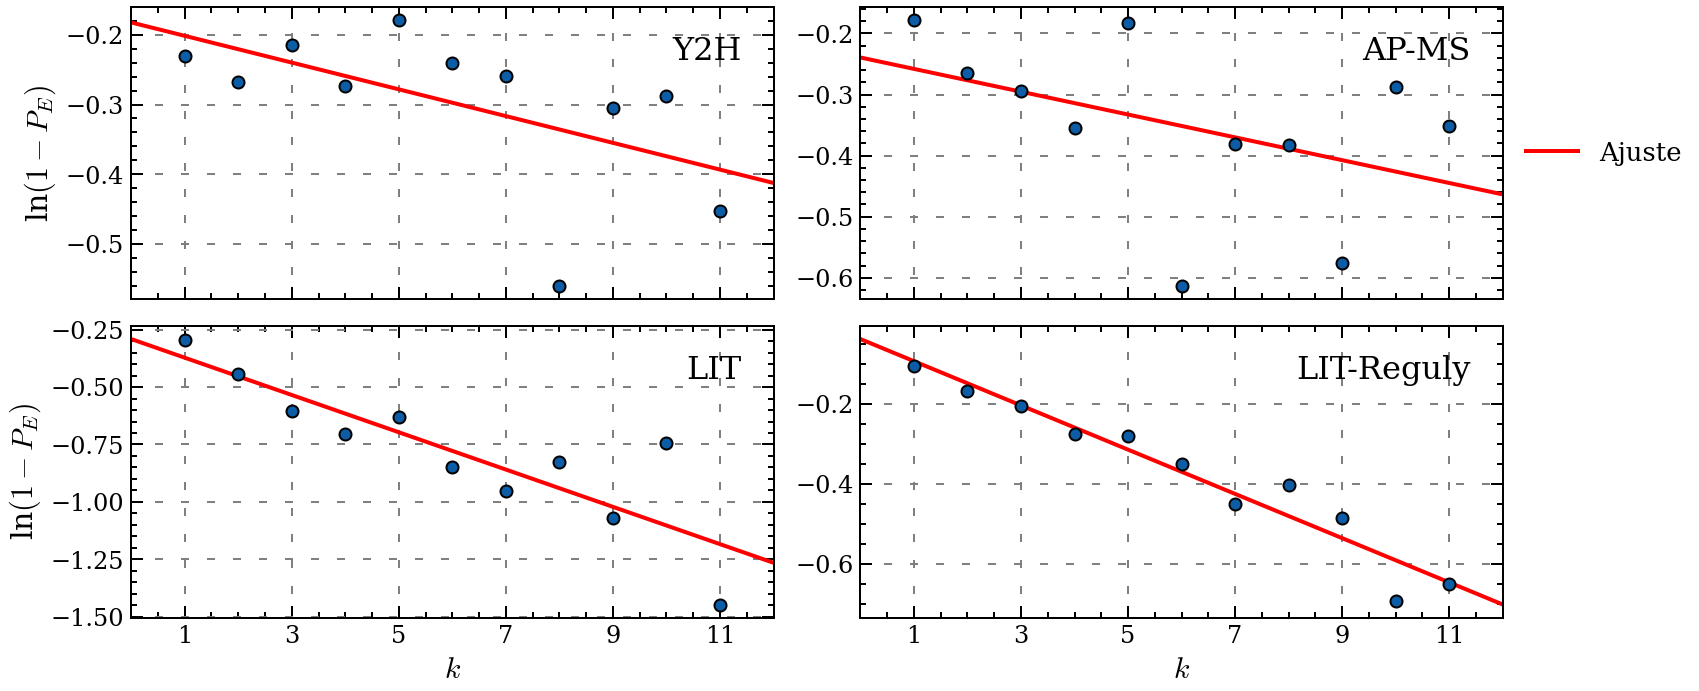

In [32]:
lineal = lambda x, a, b: a*x + b

def get_Pe(G):
    """
    Consigue los valores de Pe para cada k.
    """
    global ess_names

    gc = giant_component(G)

    nodes = list(gc.nodes())
    degrees = dict(gc.degree())

    degree_dist = dict(Counter(degrees.values()))
    ess_degrees_in_net = dict(Counter([degrees[n] for n in ess_names if n in nodes]))
    
    Pe = {k: ess_degrees_in_net[k]/degree_dist[k] for k in ess_degrees_in_net.keys()}

    return np.array(list(Pe.keys())), np.array(list(Pe.values())) 

fig, ax = plt.subplots(2, 2, figsize = (12, 5), sharex=True, tight_layout=True)
ax = ax.flatten()

for i, (net_name, G) in enumerate(nets.items()):
    x_G, y_G = get_Pe(G)
    max_k = 12
    y_G = y_G[x_G < max_k]
    x_G = x_G[x_G < max_k]
    popt, pcov = curve_fit(lineal, x_G, np.log(1 - y_G))
    ax[i].scatter(x_G, np.log(1 - y_G), ec = "black", zorder=15) #label="Valores para cada red")
    ax[i].plot(np.array([0, 12]), lineal(np.array([0, 12]), *popt), color = "red", label="Ajuste")
    ax[i].text(0.95, 0.9, net_name, ha='right', va='top',
               transform=ax[i].transAxes, fontsize=16)
    # ax[i].set_title(net_name)
    ax[i].set_xticks(np.arange(1, max_k, 2))
    ax[i].set_xlim(0, 12)

ax[1].legend(bbox_to_anchor=(1, 0.5), frameon=False, loc="center left")
ax[0].set_ylabel("ln$(1 - P_E)$")
ax[2].set_xlabel("$k$")
ax[2].set_ylabel("ln$(1 - P_E)$")
ax[3].set_xlabel("$k$")

plt.savefig("Figura 2b.png", dpi=300)
plt.show()